In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import sklearn.model_selection as sk

import plotly.express as px

import re

from io import StringIO
from IPython.display import display

from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import __version__ 


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print()
print("sklearn Version: ", __version__)
print("TF Version: ", tf.__version__)



Input files:

sklearn Version:  0.20.3
TF Version:  1.14.0
Eager mode:  False
GPU is NOT AVAILABLE
No GPU found


## Background Analysis

### Load the Data

In [33]:
#path_to_file = '/kaggle/input/wine-reviews/winemag-data-130k-v2.csv'

dfWine = pd.read_csv('train.csv')

### What do we have?
#### Exploratory analysis and descriptors of the raw dataset

In [40]:
dfWine.info()
print()
print(dfWine.shape)
print(dfWine.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
 12  year                80129 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 8.2+ MB

(82657, 13)
Index(['user_name', 'country', 'review_title', 'review_description',
       'des

In [41]:
dfWine.head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety,year
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay,2007
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend,2014
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo,2007
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend,2010
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec,2012


In [42]:
dfWine.describe()

,points,price
count,82657.000000,77088.000000
mean,88.544564,36.922232
std,3.099649,43.698346
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,45.000000
max,100.000000,3300.000000


## Data Cleaning

## Feature Extraction and Engineering

### Looks at the title of the wine and extracts the vintages out of there.
#### Creates a new column for the Vintages

In [43]:
# Read title and find vintage
yearSearch = []    
for value in dfWine['review_title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(regexresult.group())
    else: yearSearch.append(None)

dfWine['year'] = yearSearch

#Tell me which ones don't have a year listed
print(" extracted %d years from the wine titles and %d did not have a year." %(len(dfWine[dfWine['year'].notna()]), len(dfWine[dfWine['year'].isna()].index)))
dfWine['year'].describe()

 extracted 80129 years from the wine titles and 2528 did not have a year.


count     80129
unique       38
top        2012
freq      10379
Name: year, dtype: object

### Drop missing years

In [45]:
#If we're missing year values, remove the row
dfWine_goodyears=dfWine
dfWine_goodyears=dfWine_goodyears.dropna(subset=['year'])
print('Removed ' + str(dfWine.shape[0]-dfWine_goodyears.shape[0]) + ' rows with empty year values.' + "\n")

dfWine_goodyears['year']=dfWine_goodyears['year'].astype(int)

print(dfWine_goodyears['year'].describe())

dfWineYear = dfWine_goodyears.groupby(['year']).mean()
dfWineYear = pd.DataFrame(data=dfWineYear).reset_index()

Removed 2528 rows with empty year values.

count    80129.000000
mean      2010.699410
std          3.731868
min       1904.000000
25%       2009.000000
50%       2011.000000
75%       2013.000000
max       2017.000000
Name: year, dtype: float64


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Data Visualization

## Wines

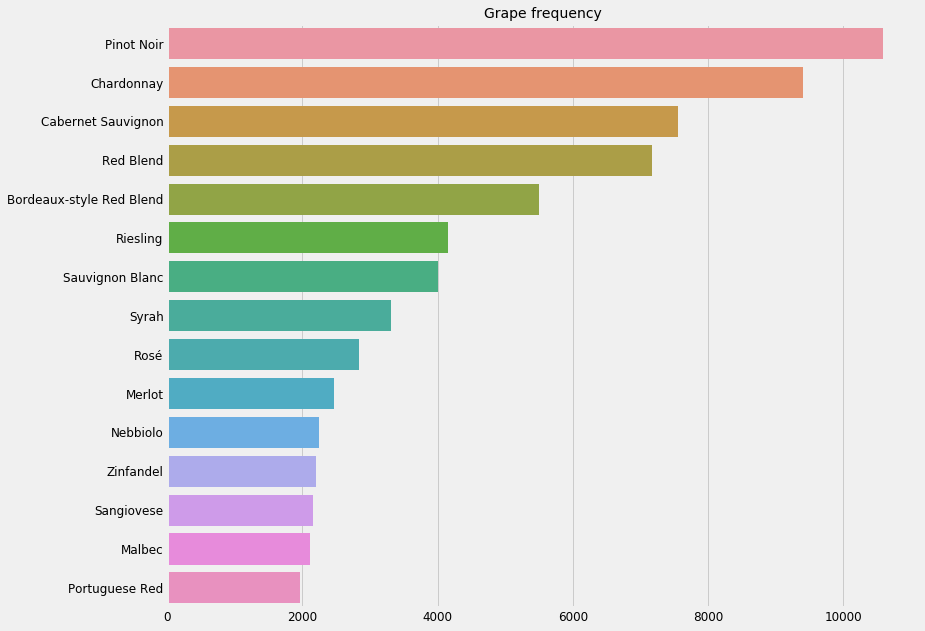

In [46]:
# Get label frequencies in descending order
label_freq = dfWine['variety'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.iloc[:15].index)
plt.title("Grape frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Classifier


### Clean into a new simpler dataframe

In [47]:
dfWineClassifier = dfWine[[ 'review_description', 'year', 'variety',  'province' ]]


print(dfWineClassifier.isnull().sum())
print()




pd.DataFrame(dfWineClassifier.variety.unique()).values



review_description       0
year                  2528
variety                  0
province                35
dtype: int64



array([['Chardonnay'],
       ['Red Blend'],
       ['Nebbiolo'],
       ['Bordeaux-style White Blend'],
       ['Malbec'],
       ['Cabernet Sauvignon'],
       ['Zinfandel'],
       ['Pinot Noir'],
       ['Sauvignon Blanc'],
       ['Gamay'],
       ['Grüner Veltliner'],
       ['Bordeaux-style Red Blend'],
       ['Sangiovese'],
       ['Syrah'],
       ['White Blend'],
       ['Cabernet Franc'],
       ['Portuguese Red'],
       ['Portuguese White'],
       ['Rhône-style Red Blend'],
       ['Rosé'],
       ['Champagne Blend'],
       ['Merlot'],
       ['Riesling'],
       ['Sparkling Blend'],
       ['Pinot Grigio'],
       ['Tempranillo'],
       ['Pinot Gris'],
       ['Gewürztraminer']], dtype=object)

### Group weird less common grapes into an "other" category

In [48]:
RARE_CUTOFF = 400 # It must have this many examples of the grape variety, otherwise it's "other."

# Create a list of rare labels
rare = list(label_freq[label_freq<RARE_CUTOFF].index)
# print("We will be ignoring these rare labels: \n", rare)


# Transform the rare ones to just "Other"
dfWineClassifier['variety'] = dfWineClassifier['variety'].apply(lambda s: str(s) if s not in rare else 'Other')

label_words = list(label_freq[label_freq>=RARE_CUTOFF].index)
label_words.append('Other')
print(label_words)

num_labels = len(label_words)
print("\n"  + str(num_labels) + " different categories.")


['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'White Blend', 'Sparkling Blend', 'Tempranillo', 'Rhône-style Red Blend', 'Pinot Gris', 'Champagne Blend', 'Cabernet Franc', 'Grüner Veltliner', 'Portuguese White', 'Pinot Grigio', 'Bordeaux-style White Blend', 'Gewürztraminer', 'Gamay', 'Other']

29 different categories.


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [49]:
# Create a new column 'category_id' with encoded categories 
dfWineClassifier['category_id'] = dfWineClassifier['variety'].factorize()[0]
category_id_df = dfWineClassifier[['variety', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'variety']].values)

# Show me the new dataframe
dfWineClassifier.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,review_description,year,variety,province,category_id
0,"Classic Chardonnay aromas of apple, pear and h...",2007,Chardonnay,Australia Other,0
1,This wine is near equal parts Syrah and Merlot...,2014,Red Blend,Washington,1
2,Barolo Conca opens with inky dark concentratio...,2007,Nebbiolo,Piedmont,2
3,It's impressive what a small addition of Sauvi...,2010,Bordeaux-style White Blend,Southwest France,3
4,"This ripe, sweet wine is rich and full of drie...",2012,Malbec,France Other,4


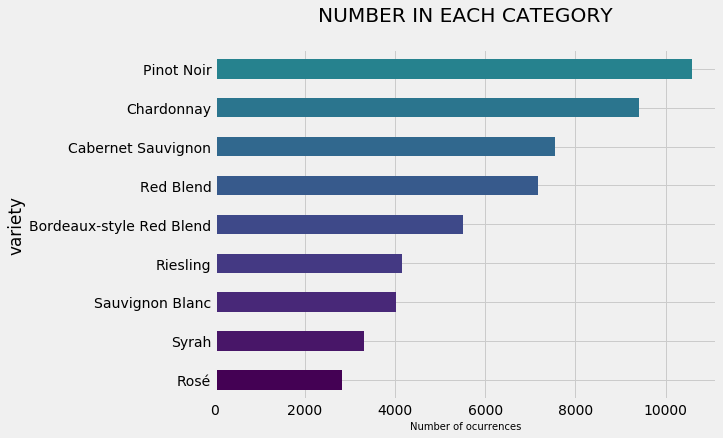

In [50]:
num_bars = 19

fig = plt.figure(figsize=(8,6))
colors = plt.cm.get_cmap('viridis', num_bars)
dfWineClassifier.groupby('variety').variety.count().sort_values()[num_bars:].plot.barh(
    ylim=0, color=colors.colors, title= 'NUMBER IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

## Preprocess

### Take a smaller sample here.

In [51]:
df2 = dfWineClassifier.sample(10000, random_state=1).copy()

### Create features and labels here

In [52]:
# Uni, bi, and trigrams requested with ngram_range=(1,3)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

# We transform each description into a vector
# we use this later in models
features = tfidf.fit_transform(df2.review_description).toarray()

labels = df2.category_id

print(labels)

print("Each of the %d descriptions is represented by %d features (TF-IDF score of unigrams and bigrams and trigrams)" %(features.shape))

40052     4
35372    22
41374     0
32224     0
79483    13
         ..
43058    18
29016    21
71519     7
37411     7
70222     7
Name: category_id, Length: 10000, dtype: int64
Each of the 10000 descriptions is represented by 11290 features (TF-IDF score of unigrams and bigrams and trigrams)


In [53]:
# Finding the three most correlated terms with each of the product categories
N = 3
for variety, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("\n==> %s:" %(variety))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
  print("  * Most Correlated Trigrams are: %s" %(', '.join(trigrams[-N:])))


==> Bordeaux-style Red Blend:
  * Most Correlated Unigrams are: 91, bordeaux, sample
  * Most Correlated Bigrams are: cabernet franc, black currant, barrel sample
  * Most Correlated Trigrams are: 92 barrel sample, bordeaux style blend, black currant fruits

==> Bordeaux-style White Blend:
  * Most Correlated Unigrams are: sémillon, herbaceous, botrytis
  * Most Correlated Bigrams are: blanc sémillon, bitter orange, herbaceous character
  * Most Correlated Trigrams are: totally ready drink, age drink 2015, flavors tropical fruit

==> Cabernet Franc:
  * Most Correlated Unigrams are: cab, francs, franc
  * Most Correlated Bigrams are: spices lead, cabernet franc, cab franc
  * Most Correlated Trigrams are: vanilla black fruit, finishes moderately long, black plums cherries

==> Cabernet Sauvignon:
  * Most Correlated Unigrams are: cabernet, cassis, cab
  * Most Correlated Bigrams are: blackberry currant, black currants, 100 cabernet
  * Most Correlated Trigrams are: currant oak flavors

# Classification


### Split into test and train

In [54]:
X = df2['review_description'] # Collection of reviews
y = df2['variety'] # Target or the labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

print('Test: ' + str(len(X_test)) + ' Train: ' + str(len(X_train)))

Test: 2500 Train: 7500


Examine a few options.

In [55]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defau

In [56]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.617258,0.012762
LogisticRegression,0.549378,0.007805
MultinomialNB,0.410607,0.002161
RandomForestClassifier,0.294084,0.006330


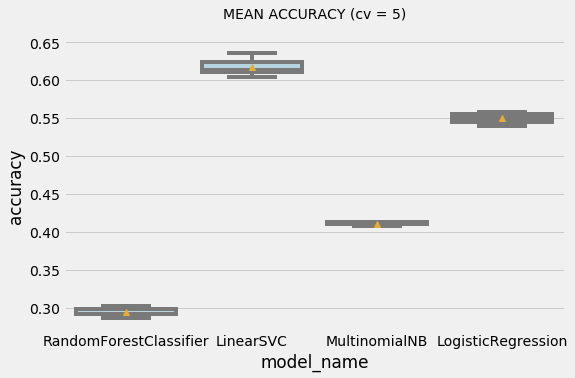

In [57]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

## Evaluate

In [58]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

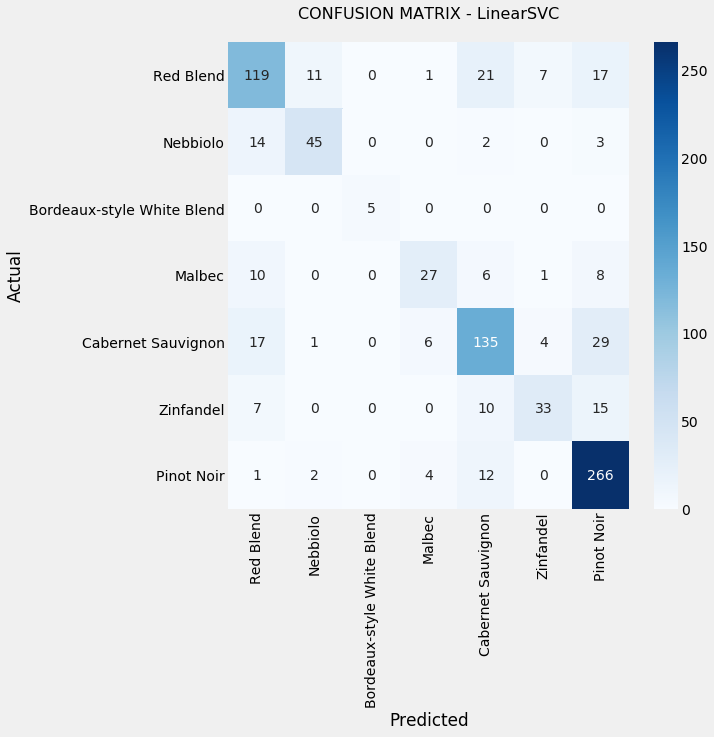

In [60]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat[1:8, 1:8], annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.variety.values[1:8], 
            yticklabels=category_id_df.variety.values[1:8])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [61]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['variety', 
                                                                'review_description']])
      print('')

'Sauvignon Blanc' predicted as 'Chardonnay' : 22 examples.


,variety,review_description
9891,Sauvignon Blanc,Sharp lime skin aromas are warmed by Gala appl...
74803,Sauvignon Blanc,"This medium-bodied, unbaked wine has light but..."
8190,Sauvignon Blanc,"Round and soft, it offers apples, citrus and g..."
65040,Sauvignon Blanc,"This is a ripe wine, with wood aging that has ..."
31384,Sauvignon Blanc,The Jim Clendenen project focuses on wines the...
66562,Sauvignon Blanc,"This wine saw no oak barrel aging, but it's so..."
77970,Sauvignon Blanc,"Aged for six months on its lees, this ripe smo..."
69887,Sauvignon Blanc,"Light, clean and fresh on the nose, this bottl..."
74671,Sauvignon Blanc,"Green bean and lettuce aromas run the tight, g..."
80489,Sauvignon Blanc,"Briny, vegetal aromas of asparagus and jalapeñ..."



'Red Blend' predicted as 'Cabernet Sauvignon' : 21 examples.


,variety,review_description
62291,Red Blend,"Dark and hearty in the glass, this blend of Me..."
43068,Red Blend,This red blend has ripe tannins and a dusty co...
57201,Red Blend,Winemaker John Kinney blends 50% Cabernet Sauv...
42145,Red Blend,Made to benefit the Wente Foundation for Arts ...
62610,Red Blend,"Quite creamy and sweet on the nose, with marsh..."
55282,Red Blend,"Made with Cabernet and Merlot, this offers sce..."
35975,Red Blend,"Earthy aromas of tobacco, olive, tree bark and..."
34522,Red Blend,"Smoky and dark, with serious aromas of black l..."
79089,Red Blend,Aromas of blackberry and cured meat give way t...
7537,Red Blend,The tomato and plum aromas in this Garnacha bl...



'Cabernet Sauvignon' predicted as 'Pinot Noir' : 29 examples.


,variety,review_description
64465,Cabernet Sauvignon,Vanilla and cinnamon notes show some oak influ...
25454,Cabernet Sauvignon,This garnet colored Bulgarian Cabernet Sauvign...
12665,Cabernet Sauvignon,"A gorgeous Cabernet, and at this price, a barg..."
65817,Cabernet Sauvignon,"A soft wine, with diluted berry and cherry fla..."
70410,Cabernet Sauvignon,"Lush and buttery with caramel notes, tar and p..."
29391,Cabernet Sauvignon,"Rich, savory and appealing now for its smooth ..."
34453,Cabernet Sauvignon,"This is a dull, tannic and robustly full bodie..."
5108,Cabernet Sauvignon,This workhorse vineyard supplies grapes to a w...
13584,Cabernet Sauvignon,"This is a big, beefy wine that smells smoky an..."
53410,Cabernet Sauvignon,"A pleasant, though somewhat generic Cabernet. ..."


In [62]:
model.fit(features, labels)

N = 4
for variety, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  trigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 3][:N]
  print("\n==> '{}':".format(variety))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))
  print("  * Top trigrams: %s" %(', '.join(trigrams)))


==> 'Bordeaux-style Red Blend':
  * Top unigrams: bordeaux, merlot, wood, franc
  * Top bigrams: cabernet franc, black currant, barrel sample, cabernet sauvignon
  * Top trigrams: juicy black currant, bordeaux style blend, ready drink 2020, bright red fruit

==> 'Bordeaux-style White Blend':
  * Top unigrams: botrytis, herbaceous, sémillon, herbaceousness
  * Top bigrams: character drink, herbal fruit, fresh grapefruit, crisp fruitiness
  * Top trigrams: flavors tropical fruit, age drink 2015, totally ready drink, worth aging years

==> 'Cabernet Franc':
  * Top unigrams: franc, francs, undergrowth, needing
  * Top bigrams: cab franc, cabernet franc, spices lead, giving wine
  * Top trigrams: spice medium bodied, merlot cabernet sauvignon, black fruit flavors, black plums cherries

==> 'Cabernet Sauvignon':
  * Top unigrams: cabernet, cab, cassis, currant
  * Top bigrams: pure cabernet, green pepper, flavors blackberries, wine quite
  * Top trigrams: 100 cabernet sauvignon, juicy red 

### Predictions

In [67]:
df3 = dfWineClassifier.sample(5000, random_state=1).copy()
X = df3['review_description'] # Collection of reviews
y = df3['variety'] # Target or the labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Predicting wine variety from the test data

In [68]:
new_review = """Nicely differentiated from the companion Stewart bottling, this Athena is a sharp and spicy affair, with tight, tart cranberry and raspberry fruit. Native yeast fermentation and extended sur-lie aging add some snap to the finish. Try after 2016 for optimum enjoyment."""
print(model.predict(fitted_vectorizer.transform([new_review])))

['Pinot Noir']


In [69]:
new_review = """Loud citrus and berry aromas precede an overloaded palate that carries stalky plum flavors. Pickled tasting on the finish."""
print(model.predict(fitted_vectorizer.transform([new_review])))

['Malbec']


# END 